## Linearizing the approximator

The other one (see previous notebook) didn't work great and was also really inefficient, worked as a proof of concept but we should improve it

Code referenced: https://github.com/pg2455/KAN-Tutorial/blob/main/1_splines.ipynb

Importing a few libaries...

In [1]:
import matplotlib.pyplot as plt
import torch

Basically I'm doing the same exercise as the tutorial but more of a straight-to-functional version and with more explanatatory comments

In [2]:
def extend_grid(grid, order):
    
    n_intervals = grid.shape[-1] - 1
    bucket_size = (grid[:, -1] - grid[:, 0]) / n_intervals

    #Add control points to grid, add the same number as the order to each side so that 
    #the interpolation can reference enough points to not lose resolution
    for i in range(order):
        grid = torch.cat([grid[:, :1] - bucket_size, grid], dim=-1)
        grid = torch.cat([grid, grid[:, -1:] + bucket_size], dim=-1)

    return grid

In [15]:
def eval_basis(samples, grid, order):

    grid_ = extend_grid(grid, order)
    samples_ = samples
    
    #Evaluating Cox-De Boor Recursion
    #Construct all bases of an order into a matrix, then move up, rather than explicitly recursing
    for i in range(order+1):
        if (i == 0):
            #Creating a matrix of basis value samples, rows are samples and columns are functions
            #Set bounds to stop it from going off the end
            bases = (samples_ >= grid_[:, :-1]) * (samples_ < grid_[:, 1:]) * 1.0 #Multiply by 1.0 to cast to float rather than bool
        else:
            #Bounds must shrink as order increases to ensure that adequate references (previous or subsequent nodes) exist
            bases1 = (samples_ - grid_[:, :-(i+1)]) / (grid_[:, 1:-i] - grid_[:, :-(i+1)]) * bases[:, :-1]
            bases2 = (grid_[:, (i+1):] - samples_) / (grid_[:, (i+1):] - grid_[:, 1:-i]) * bases[:, 1:]
            bases = bases1 + bases2

    return bases
            

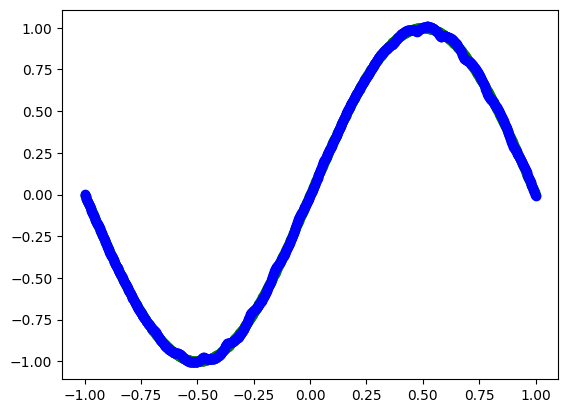

In [18]:
grid = torch.linspace(-1, 1, steps=20) #Vector of control points
samples = torch.linspace(-1, 1, steps=1000) #Vector of samples for evaluation
order = 3

#Transform to 2D for calculation purposes
grid_ = grid.unsqueeze(dim=0)
#Sample vector gets turned into a column for the formation of matrices with the grid vector
samples_ = samples.unsqueeze(dim=1)

#Create basis function matrix
basis_funcs = eval_basis(samples_, grid_, order)

#Define the function to be approximated
fn = lambda x: torch.sin(torch.pi * x) # define a function that we need to match
#Find the coefficient set using least squares function
#There's a set of coefficients per basis I think, not just a linear transform
#Like you just multiply the sample values from the basis by a coefficient vecot
#Until the result exactly matches the path of the target function
coeffs = torch.linalg.lstsq(basis_funcs.squeeze(1), fn(samples)).solution

#Multiply the coefficient vector with the feature vector of the 0th order B-spline to create the function approximation
spline = torch.einsum('i, ji -> j', coeffs, basis_funcs.squeeze(1))
plt.scatter(samples, fn(samples), color="green", label="target")
plt.scatter(samples, spline, color="blue", label="predicted")

So yeah that worked much better than the other one